# Factors behind local rental properties pricing in New York City

## Santiago Rodrigues Manica

### June 2020


## Introduction

### Background

Imagine you have the luck of owning real estate in New York City, which is available for renting. Since you live in the 8th most visited city in 2019 (https://edition.cnn.com/travel/article/most-visited-cities-euromonitor-2019/index.html), you know there is a high demand for accommodation. Since traditional hotels are especially expensive in the USA more are more tourist are looking for local and affordable accommodation. There is no surprise until 2019 companies like AirBNB kept growing ( https://news.airbnb.com/airbnb-2019-business-update/). And there is no secret, for good and for bad, that renting to short-term tourism can bring higher revenues versus having income from a long-term tenant. 

### Problem
In this case you may be a clueless owner trying to guess what factors may influence your expected pricing. Since it may be, for example, due to the neighbourhood where the rental property is located, or may be affected by convenience factors, such as proximity to restaurants and entertainment.

### Interest
In case you are a client curious about which factors may affect the price you could charge your guests, we will explore these data.


## Methods

### City of interest for this project: New York City, NY, USA

### Datasets of interest
New York’s AirBNBs (csv): https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv a freely and publicly available dataset on Kaggle, which I stored as a csv file in my GitHub account. https://github.com/RM-Santiago/Coursera_Capstone/blob/master/AB_NYC_2019.csv
Foursaquare application programming interface (API): https://developer.foursquare.com/docs/places-api/ This API will be used to obtain the venues around the rental properties and will be useful for both exploratory data analysis (EDA) and inferential analysis.

### Research questions and statistical methods:
After proper data management and EDA (including mapping and clustering), the project will try to answer to the following questions using libraries that allow data frame analysis and statistical testing (eg; Pandas):
1.	Is the average price different between neighborhoods?
Using the New York’s AirBNBs dataframe the mean and standard deviation of the price will be described across different neighborhoods and differences will be tested.  
2.	Is there an association between the average price and the neighborhood?
A simple linear regression will test the association between price (outcome/dependent variable) and the neighbourhood (categorical independent variable).
3.	Is the average price different between whole apartments and rooms?
Using the New York’s AirBNBs dataframe the mean and standard deviation of the price will be described across different types of accommodation (eg; whole apartment vs room only) and differences will be tested.  
4.	Considering the simultaneous effect of all candidate factors which may be associated with the price of a rental property?
Using the New York’s AirBNBs and adding the local venues from the API, a multiple linear regression will test the association between price (outcome/dependent variable) and a set of dependent variables (neighborhood and number of nearby venues). 

### In order to test differences of price in USD (continuous variable) between groups the following statistical tests may be used; 
•	Student’s t-test; comparing two independent groups if prices have a normal distribution;
•	Wilcoxon-Mann Whitney test; comparing two independent groups if prices have a non-normal distribution;
•	Analysis of covariance (ANOVA); when comparing prices across more than 2 independent groups if prices have a normal distribution;
•	Kruskal Wallis; when comparing prices across more than 2 independent groups if prices have a non-normal distribution.


# Starting our data analysis

Import all needed packages 

In [117]:
import pandas as pd
import numpy as np
import bs4 as bs
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
!pip install "folium"
import folium
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors
!pip install "geopy"
from geopy import OpenCage
from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

Now we are going to import the free and dataset (Which I downloaded from Kaggle and uploaded to my GitHub account) 

Here is the original website
https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

In [118]:
from urllib.request import urlretrieve
url = "https://raw.githubusercontent.com/RM-Santiago/Coursera_Capstone/master/AB_NYC_2019.csv"
urlretrieve (url, "AB_NYC_2019.csv")

airbnb = pd.read_csv("AB_NYC_2019.csv", sep=',')
airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Now we will try to count the total number of places available for AirBNB rental in NYC

In [119]:
print("Number of AirBNBs: ", airbnb.shape[0])
print("Number of rows and columns: ", airbnb.shape)

Number of AirBNBs:  48895
Number of rows and columns:  (48895, 16)


Since we only want places with a location all hotels without a latitude or longitude will be dropped.

In [120]:
print("Num of AirBNB with missing Latitude: ", airbnb.latitude.isna().sum())

Num of AirBNB with missing Latitude:  0


In [121]:
print("Num of AirBNB with missing Longitude: ", airbnb.longitude.isna().sum())

Num of AirBNB with missing Longitude:  0


Luckely there is no missing data. This means we have the latitude and longitude of 48895 places in NYC

Let's see if there is any variable with missing values

In [122]:
airbnb.count()

id                                48895
name                              48879
host_id                           48895
host_name                         48874
neighbourhood_group               48895
neighbourhood                     48895
latitude                          48895
longitude                         48895
room_type                         48895
price                             48895
minimum_nights                    48895
number_of_reviews                 48895
last_review                       38843
reviews_per_month                 38843
calculated_host_listings_count    48895
availability_365                  48895
dtype: int64

Since the host name is irrelevant it cab be dropped

In [123]:
airbnb = airbnb.drop(columns=['host_name'])
airbnb.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


You may notice that the number of reviews has NO missing data. But there are locations without a "last review". This happens because the number of reviews may be 0 (which is not a missing value). 
We are only interested in locations with a review. All locations with 0 reviews will be dropped.
Some locations have no name but we will not worry since we know all relevant data regarding their location.

In [124]:
airbnb = airbnb[airbnb.number_of_reviews != 0]
airbnb.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [137]:
airbnb.count()

id                                38061
name                              38055
host_id                           38061
neighbourhood_group               38061
neighbourhood                     38061
latitude                          38061
longitude                         38061
room_type                         38061
price                             38061
minimum_nights                    38061
number_of_reviews                 38061
last_review                       38061
reviews_per_month                 38061
calculated_host_listings_count    38061
availability_365                  38061
dtype: int64

## Drawing a beautiful map

# Now let's bring in data from Foursquare
## Neighborhood data

In [169]:
search_url = 'https://api.foursquare.com/v2/venues/search'
explore_url = 'https://api.foursquare.com/v2/venues/explore'

In [164]:
CLIENT_ID = 'AJ3IF1KBLTSZAKFZIYQK4P0J0JATC2DQVROIOA0COG51AKLF' # @hidden_cell
CLIENT_SECRET = 'TRK21OVRDMJJMPMTBCO1K3X2OSYL3VWXFC1GYA31FZJ000TO' # @hidden_cell
VERSION = '20180605' # @hidden_cell
LIMIT = 30 # @hidden_cell
print('Your credentails:') # @hidden_cell
print('CLIENT_ID: ' + CLIENT_ID) # @hidden_cell
print('CLIENT_SECRET:' + CLIENT_SECRET) # @hidden_cell

Your credentails:
CLIENT_ID: AJ3IF1KBLTSZAKFZIYQK4P0J0JATC2DQVROIOA0COG51AKLF
CLIENT_SECRET:TRK21OVRDMJJMPMTBCO1K3X2OSYL3VWXFC1GYA31FZJ000TO


In [127]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['AirBNB Name', 
                  'AirBNB Latitude', 
                  'AirBNB Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [128]:
LIMIT= 50
airbnb_venues = getNearbyVenues(names=airbnb['name'],
                                   latitudes=airbnb['latitude'],
                                   longitudes=airbnb['longitude']
                                  )

Clean & quiet apt home by the park
Skylit Midtown Castle
Cozy Entire Floor of Brownstone
Entire Apt: Spacious Studio/Loft by central park
Large Cozy 1 BR Apartment In Midtown East
BlissArtsSpace!
Large Furnished Room Near B'way 
Cozy Clean Guest Room - Family Apt
Cute & Cozy Lower East Side 1 bdrm
Beautiful 1br on Upper West Side
Central Manhattan/near Broadway
Lovely Room 1, Garden, Best Area, Legal rental
Wonderful Guest Bedroom in Manhattan for SINGLES
West Village Nest - Superhost
Only 2 stops to Manhattan studio
Perfect for Your Parents + Garden
Chelsea Perfect
Hip Historic Brownstone Apartment with Backyard
Sweet and Spacious Brooklyn Loft
CBG CtyBGd HelpsHaiti rm#1:1-4
CBG Helps Haiti Room#2.5
CBG Helps Haiti Rm #2
MAISON DES SIRENES1,bohemian apartment
Sunny Bedroom Across Prospect Park
Midtown Pied-a-terre
SPACIOUS, LOVELY FURNISHED MANHATTAN BEDROOM
Modern 1 BR / NYC / EAST VILLAGE
front room/double bed
Spacious 1 bedroom in luxe building
Loft in Williamsburg Area w/ Roof
bac

Great East Village Apartment Rental
BROWNSTONE SUNDRENCHED BEAUTY
A SpeciaL!! Private Room in NY
B NYC Staten Alternative...
C Private Room By The Ferry
Smallest House In The Village
Beautiful modern studio apartment in heart of NYC
Beautiful Landmarked Duplex
BROOKLYN > Guest Room w/ Queen Bed in Williamsburg
D Private Che@p Room 2 Explore NYC
Safe cute near subway& Manhattan NY NY retro style
Large and Cozy Private Bedroom
Small tidy bedroom in duplex
DOMINIQUE'S NY mini efficiency* wifi*metro*quiet
Private, Large & Sunny Top Floor Apt  w/W&D
Cottage in the Village
BEDROOM1 FOR RENT 10min from Manhan
Williamsburg near soho. / loftbed
BROOKLYN  STUDIO APARTMENT
BEDROOM2 FOR RENT  10min from Manh
cozy bedroom in lovely garden apt
Crown Heights Garden Apt.
Amazing  Sunny & Breezy Home In the Heart of  NYC
ENJOY Downtown NYC!!
Charming UWS Treehouse Apt
Share a HOME - $75 for 1 bdrm/++ for 2 - Brooklyn
CHARMING EAST VILLAGE 2 (or 1) BR
Farmhouse Apartment in Williamsburg
Bright+Spacious 

Large Quiet Bedroom Near Columbia U
Cozy Pre-War Harlem Apartment
spacious studio
Elegant 2-BR duplex, Union Square
Cozy private family home in Bushwick
Luxury 2Bed/2.5Bath Central Park View
Cosy Sunny 1brm in Prospect Heights
East Village bedroom w rooftop
Williamsburg Home Away From Home!
Brand New Beautiful Duplex Apartment with Garden
PRIME, Luxury, Spacious 2 Bedroom Apt in Chelsea
SPACIOUS ALCOVE STUDIO/ JUNIOR ONE
High-end doorman bldg in the LES
Spring & Mulberry 2 Bedroom Apartment
Ultra Modern NYC Garden Apartment
Modern Garden Apartment in NYC
Gorgeous Entire Manhattan Townhouse
Cozy studio Apartment in Upper East
Historic classic central cozy Village clean NYU
A PRIVATE FLAT / APARTMENT- $SPECIAL$
Williamsburg bedroom by Bedford Ave
Clean and bright with a comfortable atmosphere
WEST VILLAGE LRG CLEAN SUNNY PRIVATE BDRM
Historic Brooklyn Studio Apartment
Comfort at Crossroads of Downtown
"The Oasis" on Bedford Williamsburg
Large, sunny garden apartment.
UNION SQUARE/ E. VIL

KeyError: 'groups'

# Exploratory data analysis (EDA)

## Count number of AirBNBs per neighborhood

After having our data let's explore it

First, how many AirBNB are they on each Neighborhood?

In [76]:
airbnb.neighbourhood_group.value_counts()

Manhattan        16632
Brooklyn         16447
Queens            4574
Bronx              876
Staten Island      314
Name: neighbourhood_group, dtype: int64

What about a graph?

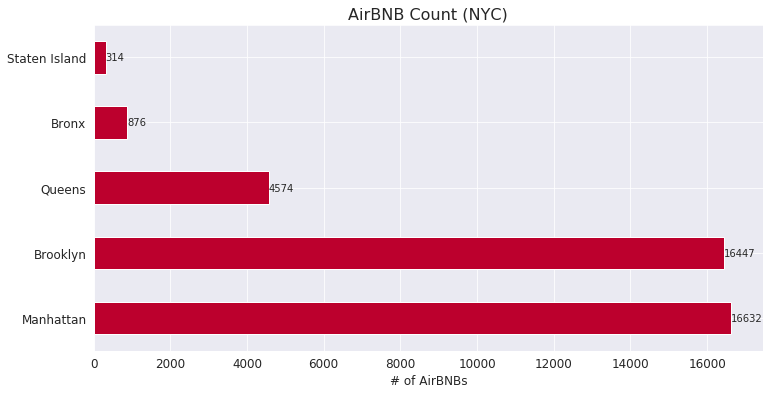

In [77]:
plt.figure(figsize=(12, 6))
ax = airbnb.neighbourhood_group.value_counts().plot(kind="barh", color="#BC002D", fontsize=12)
ax.set_title("AirBNB Count (NYC)", fontsize=16)
ax.set_xlabel("# of AirBNBs", fontsize=12)

for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width() + 0.5, p.get_y() + 0.2))

As we can see Manhattan and Brooklyn are by fare the most popular places to run a rental property

Now, let's look at a beautiful map of NYC

In [78]:
nyc_map = folium.Map(location=(40.7128, -74.0060), zoom_start=11)
nyc_map

And, now, let's add all AirBNB locations to this map

In [ ]:
nyc_map = folium.Map(location=(40.7128, -74.0060), zoom_start=11)

# add markers to map
for i in range(0,len(airbnb)):
    folium.Marker([airbnb.iloc[i]['latitude'], airbnb.iloc[i]['longitude']], popup=airbnb.iloc[i]['neighbourhood_group']).add_to(nyc_map)

nyc_map

Since Price is a very important (continuous) variable here, we need to study its distribution 

Does price have a normal distribution?

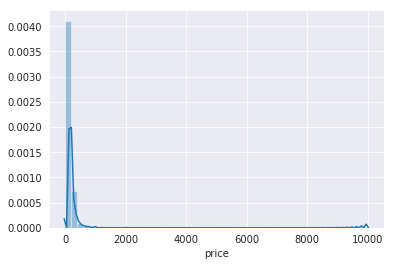

In [80]:
sns.set_style('darkgrid')
sns.distplot(airbnb['price'])

Even thoug data looks fairly normal there is a low % of outliers that push the price as high as $10,000 USD a night. 
We can eliminate the <1% outliers (most probably luxury places) since we are busy dealing with the average tourist 

In [132]:
q = airbnb["price"].quantile(0.99)

airbnb = airbnb[airbnb["price"] < q]

In [133]:
airbnb.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


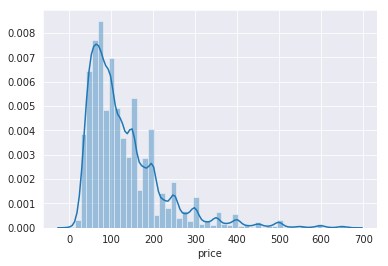

In [134]:
sns.set_style('darkgrid')
sns.distplot(airbnb['price'])

As we can see now we have something closer to a normal distribution with a shorter tail
What if we repeat the process?

In [135]:
q = airbnb["price"].quantile(0.99)

airbnb = airbnb[airbnb["price"] < q]

airbnb.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


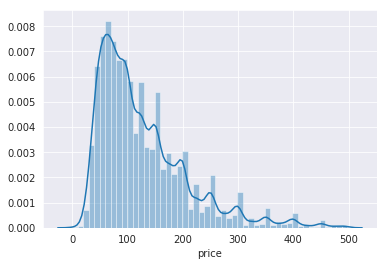

In [136]:
sns.set_style('darkgrid')
sns.distplot(airbnb['price'])

In [138]:
airbnb.count()

id                                38061
name                              38055
host_id                           38061
neighbourhood_group               38061
neighbourhood                     38061
latitude                          38061
longitude                         38061
room_type                         38061
price                             38061
minimum_nights                    38061
number_of_reviews                 38061
last_review                       38061
reviews_per_month                 38061
calculated_host_listings_count    38061
availability_365                  38061
dtype: int64

Now we have only 38061 (from an initial 48843). But it is a high number.
We are sacrificing some outliers in exchange of better power statistical techniques (assuming a normal distribution)

# Question to be answered

## 1) Is the average price different between neighborhoods?

In [139]:
avg_price_nb = airbnb['price'].groupby(airbnb['neighbourhood_group']).mean()

avg_price_nb

neighbourhood_group
Bronx             77.570447
Brooklyn         111.914303
Manhattan        154.804606
Queens            90.639737
Staten Island     88.255591
Name: price, dtype: float64

In [140]:
sd_price_nb = airbnb['price'].groupby(airbnb['neighbourhood_group']).std()

sd_price_nb

neighbourhood_group
Bronx            53.885156
Brooklyn         71.910376
Manhattan        86.553844
Queens           59.711309
Staten Island    58.579323
Name: price, dtype: float64

In [141]:
price_nb = airbnb['price'].groupby(airbnb['neighbourhood_group']).describe()

price_nb

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group,,,,,,,,
Bronx,873.0,77.570447,53.885156,0.0,45.0,64.0,93.0,450.0
Brooklyn,16255.0,111.914303,71.910376,0.0,60.0,90.0,146.5,496.0
Manhattan,16065.0,154.804606,86.553844,10.0,90.0,135.0,200.0,498.0
Queens,4555.0,90.639737,59.711309,10.0,50.0,72.0,107.5,485.0
Staten Island,313.0,88.255591,58.579323,13.0,50.0,75.0,105.0,429.0


In [142]:
mod1 = ols('price~neighbourhood',data=airbnb).fit()
aov_table1 = sm.stats.anova_lm(mod1,typ=2)
print(aov_table1)

                     sum_sq       df          F  PR(>F)
neighbourhood  5.634195e+07    217.0  51.008185     0.0
Residual       1.926273e+08  37843.0        NaN     NaN


As we can see there is a difference in the average price across different neighborhoods, in increasing order; Bronx (78), Staten Island (88), Queens (60), Brooklyn (111), and Manhattan (155). With values in USD ($). This difference is statistically relevant (p<0.05), after running an ANOVA test.

## 2) Is there an association between the average price an the neighborhood?

Here we have to run a simple linear regression, using Price as dependent variable and type of Neighborhood as independent variable.
Null hypothesis: There is no association between price and Neighborhood (p>0.05)
Alternative hypothesis: There is an association between price and Neighborhood (p<0.05)

In [143]:
dummy_ng = pd.get_dummies(airbnb['neighbourhood_group'])
dummy_ng.head()

,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,0,1,0,0,0
1,0,0,1,0,0
3,0,1,0,0,0
4,0,0,1,0,0
5,0,0,1,0,0


In [144]:
air_bnb = pd.concat([airbnb,dummy_ng],axis=1)
air_bnb.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,0,1,0,0,0
1,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,0,0,1,0,0
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,0,1,0,0,0
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,0,0,1,0,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,0,0,1,0,0


In [145]:
airbnb['neighbourhood_index']=airbnb.neighbourhood_group.map({'Staten Island':0,'Bronx':1,'Queens':2,'Brooklyn':3,'Manhattan':4})

airbnb.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_index
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,3
1,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,4
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,3
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,4
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,4


In [146]:
X1 = airbnb[['neighbourhood_index']]
Y = airbnb['price']

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X1, Y, 
                                                    test_size=0.30, 
                                                    random_state=42)

In [148]:
X_with_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_with_constant)

In [149]:
results = model.fit()
results.params

const                  30.417217
neighbourhood_index    29.763453
dtype: float64

In [150]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     2613.
Date:                Sun, 28 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:19:50   Log-Likelihood:            -1.5361e+05
No. Observations:               26642   AIC:                         3.072e+05
Df Residuals:                   26640   BIC:                         3.072e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  30.4172    

After running a simple linear regression, there is an association between Price and the Neighborhood where the rental property is located (p<0.05)

## 3) Is the average price different between whole apartments and rooms?

In [151]:
price_nb = airbnb['price'].groupby(airbnb['room_type']).describe()

price_nb

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,19636.0,171.973009,81.009001,0.0,115.0,150.0,200.0,498.0
Private room,17585.0,79.040034,44.244242,0.0,50.0,69.0,91.0,477.0
Shared room,840.0,56.582143,40.481552,0.0,32.0,45.0,69.0,400.0


In [152]:
mod2 = ols('price~room_type',data=airbnb).fit()
aov_table2 = sm.stats.anova_lm(mod2,typ=2)
print(aov_table2)

                 sum_sq       df            F  PR(>F)
room_type  8.431886e+07      2.0  9744.911702     0.0
Residual   1.646504e+08  38058.0          NaN     NaN


There average price of a rental property is different according to the room type; in increasing order; Shared room (57), Private room (79), and entire home/apartment (172). All prices are in USD ($). There is an statistically relevant difference (p<0.05), after running the ANOVA test.

## 4) Is there an association between the average price and the type of apartment?

Here we have to run a simple linear regression, using Price as dependent variable and type of rental prperty as independent variable.
Null hypothesis: There is no association between price and type of rental property (p>0.05)
Alternative hypothesis: There is an association between price and type of rental property (p<0.05)

In [153]:
airbnb['room_type_index']=airbnb.room_type.map({'Entire home/apt':0,'Private room':1,'Shared room':2})

airbnb.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_index,room_type_index
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,3,1
1,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,4,0
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,3,0
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,4,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,4,0


In [154]:
X2 = airbnb[['room_type_index']]
Y = airbnb['price']

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X2, Y, 
                                                    test_size=0.30, 
                                                    random_state=42)

In [156]:
X_with_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_with_constant)

In [157]:
results = model.fit()
results.params

const              169.858762
room_type_index    -85.431127
dtype: float64

In [158]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                 1.303e+04
Date:                Sun, 28 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:21:48   Log-Likelihood:            -1.4955e+05
No. Observations:               26642   AIC:                         2.991e+05
Df Residuals:                   26640   BIC:                         2.991e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             169.8588      0.556    3

The type of rental property is associated with price (p<0.05)

# 5) Which of these factor is associated with the price when considering all of them?

Here we have to run a multivariable linear regression, using Price as dependent variable and both neighborhood and type of rental prperty as independent variables.

In [159]:
X4 = np.column_stack((airbnb['neighbourhood_index'], airbnb['room_type_index']))
Y = airbnb['price']


In [160]:
X_train, X_test, y_train, y_test = train_test_split(X4, Y, 
                                                    test_size=0.30, 
                                                    random_state=42)

In [161]:
X_with_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_with_constant)

In [162]:
results = model.fit()
results.params

const    94.692205
x1       22.579406
x2      -80.941491
dtype: float64

In [163]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     8128.
Date:                Sun, 28 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:22:02   Log-Likelihood:            -1.4851e+05
No. Observations:               26642   AIC:                         2.970e+05
Df Residuals:                   26639   BIC:                         2.970e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         94.6922      1.701     55.656      0.0

Here we can see that both neighborhood and type of rental property are important for the pricing of the rental property, with a p-value<0.05